# Treebank NER with Bi-LSTM-CRF 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="2";  

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [6]:
from conlleval import evaluate

In [7]:
from ner_utils import *

Using TensorFlow backend.


## Get token data

In [8]:
#yap_dev = pd.read_csv('new_yap_outputs/yap_dev.csv.gz', compression='gzip')
#yap_test = pd.read_csv('new_yap_outputs/yap_test.csv.gz', compression='gzip')
yap_dev_tok = pd.read_csv('new_yap_outputs/yap_dev_tokens.csv.gz', compression='gzip').reset_index()
yap_test_tok = pd.read_csv('new_yap_outputs/yap_test_tokens.csv.gz', compression='gzip').reset_index()

In [9]:
tokens_ner_with_upos_feats = pd.read_csv('align/spmrl_tokens_df.csv.gz', compression='gzip').reset_index()

In [10]:
yap_dev_tok.head()

,index,sent,misc_token_id,misc_token_str,upostag,form,lemma,deprel,feats_gen,feats_num,feats_per,feats_tense,feats_suf_gen,feats_suf_num,feats_suf_per,sent_id
0,0,1,1,עשרות,CDT,עשרות,עשר,num,F,P,NaN,NaN,NaN,NaN,NaN,1
1,1,1,2,אנשים,NN,אנשים,איש,subj,M,P,NaN,NaN,NaN,NaN,NaN,1
2,2,1,3,מגיעים,BN,מגיעים,הגיע,conj,M,P,A,NaN,NaN,NaN,NaN,1
3,3,1,4,מתאילנד,PREPOSITION^NNP,מ^תאילנד,מ^תאילנד,comp^pobj,^F,^S,^,^,^,^,^,1
4,4,1,5,לישראל,NNP,לישראל,לישראל,nn,"F,M",S,NaN,NaN,NaN,NaN,NaN,1


In [11]:
yap_dev_tok_sents =  yap_dev_tok.groupby('sent_id')[['misc_token_str', 'upostag']].apply(lambda x: x.values.tolist())
yap_dev_tok_sents.head()

sent_id
1    [[עשרות, CDT], [אנשים, NN], [מגיעים, BN], [מתא...
2    [[תופעה, NN], [זו, PRP], [התבררה, VB], [אתמול,...
3    [[יו"ר, NNT], [הוועדה, DEF^NN], [,, yyCM], [ח"...
4    [[מצד, PREPOSITION^NN], [אחד, CD], [רוצה, BN],...
5    [[נמיר, NNP], [הודיעה, VB], [כי, CC], [תפנה, V...
dtype: object

In [12]:
yap_test_tok_sents =  yap_test_tok.groupby('sent_id')[['misc_token_str', 'upostag']].apply(lambda x: x.values.tolist())
yap_test_tok_sents.head()

sent_id
5439    [[הכל, DEF^DTT], [נושאים, NN], [עמם, VB], [את,...
5440    [[אומר, NNT], [מזכיר, NNT], [התק"ם, DEF^NNP], ...
5441    [[לא, RB], [ייתכן, MD], [שעולה, REL^NN], [יבוא...
5442    [[לא, RB], [ייתכן, MD], [שהוא, REL^PRP], [יירד...
5443    [[לכן, CC], [קבענו, VB], [עיקרון, NN], [שצריכה...
dtype: object

In [13]:
gold_dev  = tokens_ner_with_upos_feats[tokens_ner_with_upos_feats.set=='dev']
gold_train = tokens_ner_with_upos_feats[tokens_ner_with_upos_feats.set=='train']
gold_test = tokens_ner_with_upos_feats[tokens_ner_with_upos_feats.set=='test']

In [14]:
gold_dev_sents = gold_dev.groupby('sent_id')[['misc_token_str', 'upostag', 'biose']].apply(lambda x: x.values.tolist())
gold_train_sents = gold_train.groupby('sent_id')[['misc_token_str', 'upostag', 'biose']].apply(lambda x: x.values.tolist())
gold_test_sents = gold_test.groupby('sent_id')[['misc_token_str', 'upostag', 'biose']].apply(lambda x: x.values.tolist())
gold_test_sents.head()

sent_id
5439    [[הכל, NN, O], [נושאים, BN, O], [עמם, IN^S_PRN...
5440    [[אומר, BN, O], [מזכיר, NNT, O], [התק"ם, NNP, ...
5441    [[לא, RB, O], [ייתכן, MD, O], [שעולה, REL^NN, ...
5442    [[לא, RB, O], [ייתכן, MD, O], [שהוא, REL^PRP, ...
5443    [[לכן, CC, O], [קבענו, VB, O], [עיקרון, NN, O]...
dtype: object

In [15]:
gold_dev_sents.head()

sent_id
1    [[עשרות, CDT, O], [אנשים, NN, O], [מגיעים, BN,...
2    [[תופעה, NN, O], [זו, PRP, O], [התבררה, VB, O]...
3    [[יו"ר, NNT, O], [הוועדה, DEF^NN, O], [,, yyCM...
4    [[מצד, PREPOSITION^NN, O], [אחד, CD, O], [רוצה...
5    [[נמיר, NNP, S-PER], [הודיעה, VB, O], [כי, CC,...
dtype: object

In [16]:
words = list(set(tokens_ner_with_upos_feats.misc_token_str.values)|set(yap_dev_tok.misc_token_str.values)|set(yap_test_tok.misc_token_str.values))
n_words = len(words); n_words

28714

In [17]:
tags = list(set(tokens_ner_with_upos_feats.biose.values))
n_tags = len(tags); n_tags

36

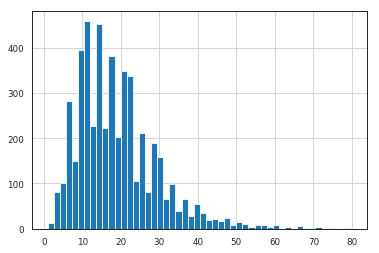

In [18]:
gold_train.groupby('sent_id').size().hist(bins=50)

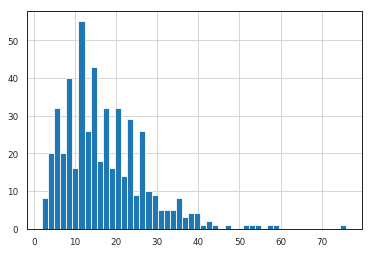

In [19]:
yap_dev_tok.groupby('sent_id').size().hist(bins=50)

In [20]:
max_len = 80
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [21]:
from keras.preprocessing.sequence import pad_sequences
X_gold_train = [[word2idx[w[0]] for w in s] for s in gold_train_sents]
X_gold_dev   = [[word2idx[w[0]] for w in s] for s in gold_dev_sents]
X_gold_test  = [[word2idx[w[0]] for w in s] for s in gold_test_sents]
X_yap_dev    = [[word2idx[w[0]] for w in s] for s in yap_dev_tok_sents]
X_yap_test   = [[word2idx[w[0]] for w in s] for s in yap_test_tok_sents]

In [22]:
X_gold_train = pad_sequences(maxlen=max_len, sequences=X_gold_train, value=word2idx["PAD"], padding='post', truncating='post')
X_gold_dev   = pad_sequences(maxlen=max_len, sequences=X_gold_dev  , value=word2idx["PAD"], padding='post', truncating='post')
X_gold_test  = pad_sequences(maxlen=max_len, sequences=X_gold_test , value=word2idx["PAD"], padding='post', truncating='post')
X_yap_dev    = pad_sequences(maxlen=max_len, sequences=X_yap_dev   , value=word2idx["PAD"], padding='post', truncating='post')
X_yap_test   = pad_sequences(maxlen=max_len, sequences=X_yap_test  , value=word2idx["PAD"], padding='post', truncating='post')
X_gold_train[0]

array([19318,  5870, 20115, 14258, 28705,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [23]:
pos = list(set(tokens_ner_with_upos_feats.upostag.values)|set(yap_dev_tok.upostag.values)|set(yap_test_tok.upostag.values))
n_pos = len(pos); n_pos

352

In [24]:
pos2idx = {w: i+1 for i, w in enumerate(pos)}
pos2idx["PAD"] = 0

In [25]:
from keras.preprocessing.sequence import pad_sequences
X_pos_gold_train = [[pos2idx[w[1]] for w in s] for s in gold_train_sents]
X_pos_gold_dev   = [[pos2idx[w[1]] for w in s] for s in gold_dev_sents]
X_pos_gold_test  = [[pos2idx[w[1]] for w in s] for s in gold_test_sents]
X_pos_yap_dev    = [[pos2idx[w[1]] for w in s] for s in yap_dev_tok_sents]
X_pos_yap_test   = [[pos2idx[w[1]] for w in s] for s in yap_test_tok_sents]

In [26]:
X_pos_gold_train = pad_sequences(maxlen=max_len, sequences=X_pos_gold_train, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_dev   = pad_sequences(maxlen=max_len, sequences=X_pos_gold_dev  , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_test  = pad_sequences(maxlen=max_len, sequences=X_pos_gold_test , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_yap_dev    = pad_sequences(maxlen=max_len, sequences=X_pos_yap_dev   , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_yap_test   = pad_sequences(maxlen=max_len, sequences=X_pos_yap_test  , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_train[0]

array([ 31, 161,  12, 122, 257,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [27]:
from keras.preprocessing.sequence import pad_sequences
y_gold_train = [[tag2idx[w[2]] for w in s] for s in gold_train_sents]
y_gold_dev   = [[tag2idx[w[2]] for w in s] for s in gold_dev_sents]
y_gold_test  = [[tag2idx[w[2]] for w in s] for s in gold_test_sents]

In [28]:
y_numer_gold_train = pad_sequences(maxlen=max_len, sequences=y_gold_train, value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_dev   = pad_sequences(maxlen=max_len, sequences=y_gold_dev  , value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_test  = pad_sequences(maxlen=max_len, sequences=y_gold_test , value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_train[0]

array([4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [29]:
from keras.utils import to_categorical
y_gold_train = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_train]
y_gold_dev   = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_dev  ]
y_gold_test  = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_test ]

y_gold_train[0].shape

(80, 37)

In [30]:
validation_split = len(X_gold_dev) / (len(X_gold_train)+len(X_gold_dev))
validation_split

0.09196247930844216

In [31]:
splits = [[X_gold_train, X_gold_dev,
           y_gold_train, y_gold_dev,
           X_pos_gold_train, X_pos_gold_dev ]]

### Prep char input

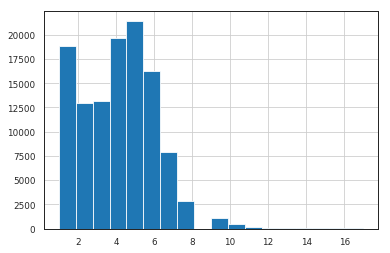

In [32]:
tokens_ner_with_upos_feats.misc_token_str.apply(len).hist(bins=18)

In [33]:
max_len_char = 12

In [34]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

50


In [35]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [36]:

def get_X_char(sents):
    X_char = []
    for sentence in sents:
        sent_seq = []
        for i in range(max_len):
            word_seq = []
            for j in range(max_len_char):
                try:
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                except:
                    word_seq.append(char2idx.get("PAD"))
            sent_seq.append(word_seq)
        X_char.append(np.array(sent_seq))
    return X_char

In [37]:
X_char_gold_dev   = get_X_char(gold_dev_sents  )
X_char_gold_train = get_X_char(gold_train_sents)
X_char_gold_test  = get_X_char(gold_test_sents )
X_char_yap_dev    = get_X_char(yap_dev_tok_sents   )
X_char_yap_test   = get_X_char(yap_test_tok_sents  )



splits_char = [[X_char_gold_train, X_char_gold_dev,
                y_gold_train, y_gold_dev]]

## Embeddings

In [38]:
embedding_paths

{'yap_w2v_sg': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_skipgram.txt',
 'yap_w2v_cbow': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_cbow.txt',
 'yap_glove': '../wordembedding-hebrew/glove/wikipedia.yap_form.glove.txt.txt',
 'yap_ft_sg': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec',
 'yap_ft_cbow': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_cbow.model.vec',
 'token_w2v_sg': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_skipgram.txt',
 'token_w2v_cbow': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_cbow.txt',
 'token_glove': '../wordembedding-hebrew/glove/wikipedia.tokenized.glove.txt',
 'token_ft_sg': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_skipgram.model.vec',
 'token_ft_cbow': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_cbow.model.vec',
 'pretrained_token_ft': '../fasttext/wiki.he.vec'}

In [39]:
exclude = ['cbow', 'word2vec', 'yap', 'glove']

In [40]:
embedding_mats = {}
for emb_name, emb_path in embedding_paths.items():
    skip=False
    for exc in exclude:
        if exc in emb_path:
            skip=True
    if skip:
        continue
    embedding_mats[emb_name] = get_embedding_matrix(emb_path, word2idx)

loading word embeddings: ../wordembedding-hebrew/wikipedia.tokenized.fasttext_skipgram.model.vec
found 372587 word vectors
preparing embedding matrix...
number of null word embeddings: 3040
sample words not found:  ['המקס' 'בהכתמה' 'ותרומתי' 'שלבנק' 'טוניאצי' 'ל"אוכלי' 'ותיאוריית'
 'טרייכמן' 'הוצאנו' 'ומשוריינת']
loading word embeddings: ../fasttext/wiki.he.vec
found 488194 word vectors
preparing embedding matrix...
number of null word embeddings: 2966
sample words not found:  ['ל004' 'יוגוסלווית' 'גזיזולין' 'חיכיתם' 'וצחק' 'שלקמחי' 'ויסמונסקי'
 'המשתקות' 'בדו"ח' 'ב"דיפרנסיאס']


## Model building

In [41]:
configs = build_configs(base_configs, embedding_mats)
configs     

[{'crf': True, 'use_pos': False},
 {'crf': True, 'use_pos': True},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'pretrained_token_ft',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': True,
  'embedding_matrix': 'token_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': True,
  'embedding_matrix': 'pretrained_token_ft',
  'trainable': True,
  'embed_dim': 300},
 {'use_char': True, 'crf': True, 'use_pos': False},
 {'use_char': True, 'crf': True, 'use_pos': True},
 {'add_random_embedding': False,
  'use_char': True,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'use_char': True,
  'crf':

In [42]:
out_folder = 'results/new_outputs'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [43]:
extra_preds = [(X_gold_test, X_pos_gold_test, X_char_gold_test), 
               (X_yap_dev, X_pos_yap_dev, X_char_yap_dev),
               (X_yap_test, X_pos_yap_test, X_char_yap_test)]

In [ ]:
from ner_utils import *

Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 57s - loss: 0.2994 - crf_accuracy: 0.9355 - val_loss: 0.1713 - val_crf_accuracy: 0.9682
Epoch 2/100
 - 54s - loss: 0.1118 - crf_accuracy: 0.9763 - val_loss: 0.1459 - val_crf_accuracy: 0.9697
Epoch 3/100
 - 51s - loss: 0.0758 - crf_accuracy: 0.9800 - val_loss: 0.1158 - val_crf_accuracy: 0.9730
Epoch 4/100
 - 54s - loss: 0.0522 - crf_accuracy: 0.9851 - val_loss: 0.1084 - val_crf_accuracy: 0.9743
Epoch 5/100
 - 53s - loss: 0.0354 - crf_accuracy: 0.9884 - val_loss: 0.0982 - val_crf_accuracy: 0.9727
Epoch 6/100
 - 49s - loss: 0.0238 - crf_accuracy: 0.9908 - val_loss: 0.0997 - val_crf_accuracy: 0.9692
Epoch 7/100
 - 52s - loss: 0.0152 - crf_accuracy: 0.9923 - val_loss: 0.0944 - val_crf_accuracy: 0.9716
Epoch 8/100
 - 52s - loss: 0.0079 - crf_accuracy: 0.9938 - val_loss: 0.1032 - val_crf_accuracy: 0.9679
Epoch 9/100
 - 48s - loss: 0.0022 - crf_accuracy: 0.9947 - val_loss: 0.1065 - val_crf_accuracy: 0.9748
Epoch 10/100
 - 55s - loss

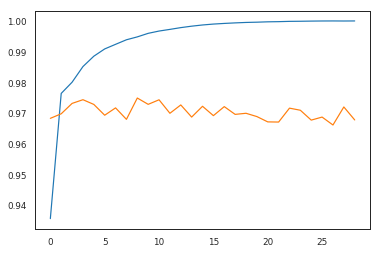

processed 8531 tokens with 499 phrases; found: 398 phrases; correct: 167.
accuracy:  33.49%; (non-O)
accuracy:  91.76%; precision:  41.96%; recall:  33.47%; FB1:  37.24
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
              GPE: precision:  65.06%; recall:  44.63%; FB1:  52.94  83
              LOC: precision:  41.18%; recall:  25.00%; FB1:  31.11  17
              ORG: precision:  23.57%; recall:  27.73%; FB1:  25.48  140
              PER: precision:  50.00%; recall:  37.82%; FB1:  43.07  146
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  8
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 55s - loss: 0.3003 - crf_accuracy: 0.9376 - val_loss: 0.1625 - val_crf_accuracy: 0.9681
Epoch 2/100
 - 52s - loss: 0.0915 - 

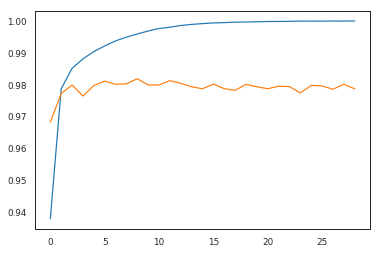

processed 8531 tokens with 499 phrases; found: 513 phrases; correct: 275.
accuracy:  51.69%; (non-O)
accuracy:  94.01%; precision:  53.61%; recall:  55.11%; FB1:  54.35
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  10
              GPE: precision:  67.59%; recall:  60.33%; FB1:  63.76  108
              LOC: precision:  24.07%; recall:  46.43%; FB1:  31.71  54
              ORG: precision:  33.06%; recall:  33.61%; FB1:  33.33  121
              PER: precision:  68.98%; recall:  77.20%; FB1:  72.86  216
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 53s - loss: 0.2304 - crf_accuracy: 0.9521 - val_loss: 0.1077 - val_crf_accuracy: 0.9737
Epoch 2/100
 - 50s - loss: 0.0564 

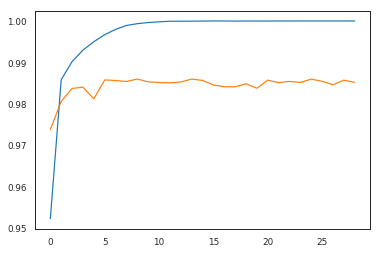

processed 8531 tokens with 499 phrases; found: 481 phrases; correct: 333.
accuracy:  64.46%; (non-O)
accuracy:  95.60%; precision:  69.23%; recall:  66.73%; FB1:  67.96
              ANG: precision: 100.00%; recall:  33.33%; FB1:  50.00  1
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:  16.67%; recall:   8.33%; FB1:  11.11  6
              GPE: precision:  82.14%; recall:  76.03%; FB1:  78.97  112
              LOC: precision:  48.72%; recall:  67.86%; FB1:  56.72  39
              ORG: precision:  59.22%; recall:  51.26%; FB1:  54.95  103
              PER: precision:  73.71%; recall:  81.35%; FB1:  77.34  213
              WOA: precision:  16.67%; recall:  11.11%; FB1:  13.33  6
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 55s - loss: 0.2138 - crf_accuracy: 0.9572 - val_loss: 0.1005 - val_crf_accuracy: 0.9760
Epoch 2/100
 - 47s - loss: 0.0575 -

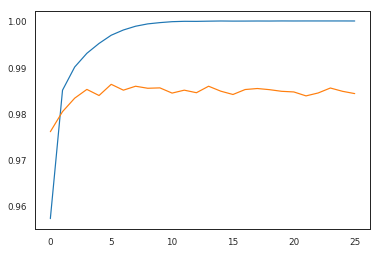

processed 8531 tokens with 499 phrases; found: 431 phrases; correct: 307.
accuracy:  60.60%; (non-O)
accuracy:  95.70%; precision:  71.23%; recall:  61.52%; FB1:  66.02
              ANG: precision: 100.00%; recall:  33.33%; FB1:  50.00  1
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
              GPE: precision:  79.46%; recall:  73.55%; FB1:  76.39  112
              LOC: precision:  63.64%; recall:  50.00%; FB1:  56.00  22
              ORG: precision:  56.25%; recall:  45.38%; FB1:  50.23  96
              PER: precision:  78.19%; recall:  76.17%; FB1:  77.17  188
              WOA: precision:  22.22%; recall:  22.22%; FB1:  22.22  9
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 58s - loss: 0.2386 - crf_accuracy: 0.9516 - val_loss: 0.0901 - val_crf_accuracy: 0.9770
Epoch 2/100
 - 50s - loss: 0.0492 - 

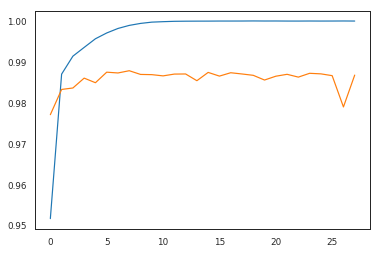

processed 8531 tokens with 499 phrases; found: 461 phrases; correct: 354.
accuracy:  66.39%; (non-O)
accuracy:  96.44%; precision:  76.79%; recall:  70.94%; FB1:  73.75
              ANG: precision: 100.00%; recall:  33.33%; FB1:  50.00  1
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              GPE: precision:  85.34%; recall:  81.82%; FB1:  83.54  116
              LOC: precision:  58.06%; recall:  64.29%; FB1:  61.02  31
              ORG: precision:  67.03%; recall:  51.26%; FB1:  58.10  91
              PER: precision:  79.82%; recall:  90.16%; FB1:  84.67  218
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 57s - loss: 0.2272 - crf_accuracy: 0.9544 - val_loss: 0.0961 - val_crf_accuracy: 0.9770
Epoch 2/100
 - 49s - loss: 0.0507 - 

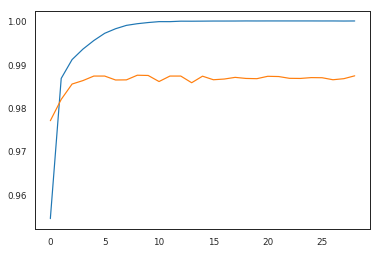

processed 8531 tokens with 499 phrases; found: 476 phrases; correct: 351.
accuracy:  68.43%; (non-O)
accuracy:  96.30%; precision:  73.74%; recall:  70.34%; FB1:  72.00
              ANG: precision: 100.00%; recall:  33.33%; FB1:  50.00  1
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:  16.67%; recall:   8.33%; FB1:  11.11  6
              GPE: precision:  81.20%; recall:  78.51%; FB1:  79.83  117
              LOC: precision:  61.29%; recall:  67.86%; FB1:  64.41  31
              ORG: precision:  54.69%; recall:  58.82%; FB1:  56.68  128
              PER: precision:  88.17%; recall:  84.97%; FB1:  86.54  186
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 66s - loss: 0.3019 - crf_accuracy: 0.9378 - val_loss: 0.1874 - val_crf_accuracy: 0.9683
Epoch 2/100
 - 57s - loss: 0.1175 -

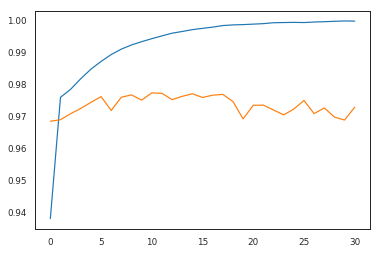

processed 8531 tokens with 499 phrases; found: 452 phrases; correct: 201.
accuracy:  38.07%; (non-O)
accuracy:  92.18%; precision:  44.47%; recall:  40.28%; FB1:  42.27
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
              GPE: precision:  55.83%; recall:  55.37%; FB1:  55.60  120
              LOC: precision:  33.33%; recall:  28.57%; FB1:  30.77  24
              ORG: precision:  40.48%; recall:  28.57%; FB1:  33.50  84
              PER: precision:  43.96%; recall:  47.15%; FB1:  45.50  207
              WOA: precision:   8.33%; recall:  11.11%; FB1:   9.52  12
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 63s - loss: 0.3008 - crf_accuracy: 0.9383 - val_loss: 0.1692 - val_crf_accuracy: 0.9683
Epoch 2/100
 - 59s - loss: 0.0938 -

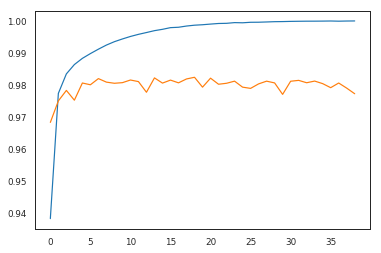

processed 8531 tokens with 499 phrases; found: 506 phrases; correct: 277.
accuracy:  51.08%; (non-O)
accuracy:  94.15%; precision:  54.74%; recall:  55.51%; FB1:  55.12
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  9
              FAC: precision:   3.33%; recall:   8.33%; FB1:   4.76  30
              GPE: precision:  63.79%; recall:  61.16%; FB1:  62.45  116
              LOC: precision:  29.27%; recall:  42.86%; FB1:  34.78  41
              ORG: precision:  56.34%; recall:  33.61%; FB1:  42.11  71
              PER: precision:  66.52%; recall:  76.17%; FB1:  71.01  221
              WOA: precision:  33.33%; recall:  33.33%; FB1:  33.33  9
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 59s - loss: 0.2310 - crf_accuracy: 0.9594 - val_loss: 0.1086 - val_crf_accuracy: 0.9739
Epoch 2/100
 - 52s - loss: 0.0678 -

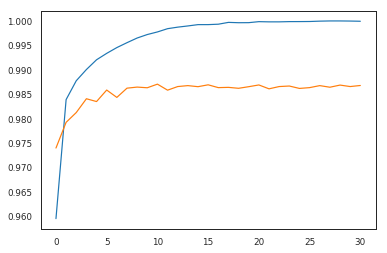

processed 8531 tokens with 499 phrases; found: 469 phrases; correct: 343.
accuracy:  66.51%; (non-O)
accuracy:  95.94%; precision:  73.13%; recall:  68.74%; FB1:  70.87
              ANG: precision: 100.00%; recall:  33.33%; FB1:  50.00  1
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              GPE: precision:  78.69%; recall:  79.34%; FB1:  79.01  122
              LOC: precision:  53.12%; recall:  60.71%; FB1:  56.67  32
              ORG: precision:  68.48%; recall:  52.94%; FB1:  59.72  92
              PER: precision:  76.74%; recall:  85.49%; FB1:  80.88  215
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 59s - loss: 0.2369 - crf_accuracy: 0.9526 - val_loss: 0.1071 - val_crf_accuracy: 0.9736
Epoch 2/100
 - 51s - loss: 0.0653 - 

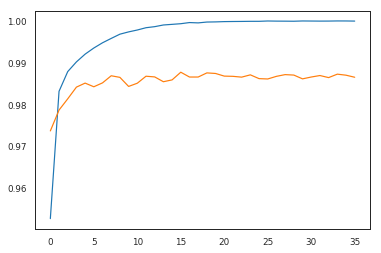

processed 8531 tokens with 499 phrases; found: 448 phrases; correct: 329.
accuracy:  64.22%; (non-O)
accuracy:  95.89%; precision:  73.44%; recall:  65.93%; FB1:  69.48
              ANG: precision: 100.00%; recall:  33.33%; FB1:  50.00  1
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
              GPE: precision:  77.78%; recall:  75.21%; FB1:  76.47  117
              LOC: precision:  60.71%; recall:  60.71%; FB1:  60.71  28
              ORG: precision:  66.67%; recall:  50.42%; FB1:  57.42  90
              PER: precision:  82.98%; recall:  80.83%; FB1:  81.89  188
              WOA: precision:  15.00%; recall:  33.33%; FB1:  20.69  20
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 60s - loss: 0.2303 - crf_accuracy: 0.9552 - val_loss: 0.0999 - val_crf_accuracy: 0.9748
Epoch 2/100
 - 51s - loss: 0.0577 -

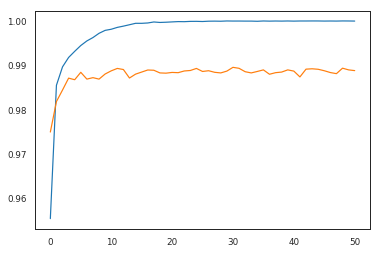

processed 8531 tokens with 499 phrases; found: 458 phrases; correct: 359.
accuracy:  68.80%; (non-O)
accuracy:  96.57%; precision:  78.38%; recall:  71.94%; FB1:  75.03
              ANG: precision: 100.00%; recall:  66.67%; FB1:  80.00  2
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:  50.00%; recall:   8.33%; FB1:  14.29  2
              FAC: precision:  33.33%; recall:   8.33%; FB1:  13.33  3
              GPE: precision:  85.96%; recall:  80.99%; FB1:  83.40  114
              LOC: precision:  62.07%; recall:  64.29%; FB1:  63.16  29
              ORG: precision:  68.04%; recall:  55.46%; FB1:  61.11  97
              PER: precision:  83.01%; recall:  88.60%; FB1:  85.71  206
              WOA: precision:  40.00%; recall:  22.22%; FB1:  28.57  5
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 61s - loss: 0.2194 - crf_accuracy: 0.9576 - val_loss: 0.1042 - val_crf_accuracy: 0.9738
Epoch 2/100
 - 54s - loss: 0.0574 - 

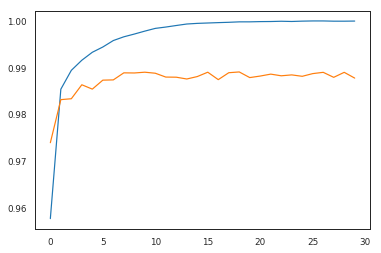

processed 8531 tokens with 499 phrases; found: 458 phrases; correct: 363.
accuracy:  69.28%; (non-O)
accuracy:  96.75%; precision:  79.26%; recall:  72.75%; FB1:  75.86
              ANG: precision: 100.00%; recall:  66.67%; FB1:  80.00  2
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:  33.33%; recall:  16.67%; FB1:  22.22  6
              GPE: precision:  85.71%; recall:  79.34%; FB1:  82.40  112
              LOC: precision:  58.62%; recall:  60.71%; FB1:  59.65  29
              ORG: precision:  70.21%; recall:  55.46%; FB1:  61.97  94
              PER: precision:  84.95%; recall:  90.67%; FB1:  87.72  206
              WOA: precision:  50.00%; recall:  44.44%; FB1:  47.06  8


In [ ]:
configs, results, preds, histories = run_models(configs, splits, splits_char, embedding_mats, 
                                                words, max_len, n_words, idx2word, idx2tag,
                                                n_tags, max_len_char, n_pos, n_chars,
                                                run_name='treebank_tokens_fixed2', out_folder=out_folder,
                                                skip_if_model_exists=True,
                                                validation_split=validation_split,
                                                extra_predictions=extra_preds,
                                                )